In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import decoupler
import pandas as pd
import numpy as np
import random
import sc_toolbox
import scipy

from scipy.sparse import csr_matrix, isspmatrix
from anndata2ri import converter
from datetime import datetime

import rpy2.rinterface_lib.callbacks
import anndata2ri
import logging

from rpy2.robjects import pandas2ri
from rpy2.robjects import r

In [3]:
import sys
sys.path.append('..')

from src.configs import config
from src.utils import visualise as vs
from src.utils import utils as us
%load_ext autoreload
%autoreload 2

In [4]:
sc.settings.verbosity = 0
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

pandas2ri.activate()
anndata2ri.activate()
time_start = datetime.now()
%load_ext rpy2.ipython
warnings.filterwarnings("once")
warnings.filterwarnings("ignore", category=FutureWarning)

In [5]:
%%R
source(here::here('src/modules/DEG.R'))

/home/vess/Distr/conda/envs/HT/lib/python3.9/site-packages/rpy2/ipython/rmagic.py:984: DeprecationWarning: The `source` parameter emit a  deprecation warning since IPython 8.0, it had no effects for a long time and will  be removed in future versions.
  displaypub.publish_display_data(


Loading required package: limma
In addition: Warning message:
In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
  libraries ‘/usr/local/lib/R/site-library’, ‘/usr/lib/R/site-library’ contain no packages


# Load Data

In [6]:
adata = sc.read(config.PATHS.LOGS/'Norm.h5ad')

print(adata.shape)
print('isspmatrix:', isspmatrix(adata.X))


print('Loaded Filtered AnnData object: number of cells', adata.n_obs)
print('Loaded Filtered AnnData object: number of genes', adata.n_vars) 
print('Available metadata for each cell: ', adata.obs.columns)

(24549, 15223)
isspmatrix: True
Loaded Filtered AnnData object: number of cells 24549
Loaded Filtered AnnData object: number of genes 15223
Available metadata for each cell:  Index(['timepoint', 'line', '10X_date', 'clusters', 'tSNE_1', 'tSNE_2',
       'cluster', 'timepoint_mapped', 'batch', 'dataset', 'isHuman', 'isESC',
       'n_genes_by_counts', 'total_counts', 'total_counts_mito',
       'pct_counts_mito', 'total_counts_ribo', 'pct_counts_ribo',
       'QC_doublets', 'n_genes', 'n_counts'],
      dtype='object')


In [7]:
adata.obs['time'] = adata.obs.timepoint_mapped.apply(
    lambda x: 'd{}'.format(x)).copy()
adata.obs['isHuman'] = adata.obs.line.apply(
    lambda x: x.lower() in config.HUMANS).copy()

In [8]:
adata.obs['sample'] = adata.obs.line.astype(str) \
    + '_' + adata.obs.batch.astype(str) \
    + '_' + adata.obs.timepoint_mapped.astype(str)
obs_to_keep = ["sample", "cluster", "batch", "line", "time", "isHuman"]

In [9]:
if config.PROTO.SUBSET.USE_HIGHLY_VARIABLE:
    adata = adata[:, adata.var.highly_variable]
adata.X = adata.layers["counts"].copy()

# Exclude Non-Human

In [32]:
idxs = np.prod([
    adata.obs.time.apply(lambda x: x in [ 'd35' ]),#, 'd35' ]),
], axis=0, dtype=np.bool_)
selected = adata[idxs, :].copy()
selected.obs.head()

,timepoint,line,10X_date,clusters,tSNE_1,tSNE_2,cluster,timepoint_mapped,batch,dataset,...,total_counts,total_counts_mito,pct_counts_mito,total_counts_ribo,pct_counts_ribo,QC_doublets,n_genes,n_counts,time,sample
AAACCTGCATCTCCCA-7.w5_409b2_180221,w5,409b2,180221,C6,102.806594,15.136167,C6,35,180221_b1,EMATB,...,21468,331,1.541830,4247,19.782933,0.054152,5017,21468,d35,409b2_180221_b1_35
AAACGGGAGTTTCCTT-7.w5_409b2_180221,w5,409b2,180221,C6,83.221543,28.021422,C6,35,180221_b1,EMATB,...,9885,134,1.355589,2021,20.445119,0.079646,3334,9885,d35,409b2_180221_b1_35
AAACGGGCAGAGTGTG-7.w5_409b2_180221,w5,409b2,180221,C6,103.988433,12.221407,C6,35,180221_b1,EMATB,...,15374,288,1.873293,3593,23.370626,0.043668,4207,15374,d35,409b2_180221_b1_35
AAAGATGAGCGCTCCA-7.w5_409b2_180221,w5,409b2,180221,C6,97.975985,1.739824,C6,35,180221_b1,EMATB,...,11773,191,1.622356,2495,21.192559,0.064220,3579,11773,d35,409b2_180221_b1_35
AAAGATGTCGAATGGG-7.w5_409b2_180221,w5,409b2,180221,C5,37.781192,-83.644176,C5,35,180221_b1,EMATB,...,5193,75,1.444252,769,14.808396,0.040593,2172,5193,d35,409b2_180221_b1_35


In [33]:
if config.PROTO.PSEUDO_BULK.TYPE == 'decoupler':
    adata_pb = decoupler.get_pseudobulk(
        selected, 'sample', 'cluster', selected.obs,
        min_cells=config.PROTO.GLM.MIN_CELLS,
        mode=config.PROTO.GLM.PSEUDOBULK_MODE)
assert config.PROTO.PSEUDO_BULK.TYPE == 'decoupler', 'NOT SUPPORTED ATM'

/home/vess/Distr/conda/envs/HT/lib/python3.9/site-packages/anndata/_core/anndata.py:447: PendingDeprecationWarning: The dtype argument will be deprecated in anndata 0.10.0
  warnings.warn(


# edgeR

In [34]:
adata_mono = adata_pb[
    adata_pb.obs.cluster.apply(
        lambda x: x in 
        [ 'C2', 'C3', 'C4', 'C5', 'C6', 'C7' ])].copy()
# adata_mono = adata_pb.copy()
adata_mono

AnnData object with n_obs × n_vars = 45 × 5000
    obs: 'timepoint', 'line', '10X_date', 'clusters', 'cluster', 'timepoint_mapped', 'batch', 'dataset', 'isHuman', 'isESC', 'time', 'sample', 'psbulk_n_cells', 'psbulk_counts'
    var: 'mito', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'triku_distance', 'triku_distance_uncorrected', 'triku_highly_variable'
    layers: 'psbulk_props'

In [35]:
filter_low_counts = config.PROTO.GLM.FILTER

In [36]:
%%time
%%R -i adata_mono -i filter_low_counts -o tt

outs <- degs(adata_mono, filter_low_counts)

myContrast <- makeContrasts(
    "isHumanTRUE-isHumanFALSE", levels=outs$y$design)
qlf <- glmQLFTest(outs$fit, contrast=myContrast)
# get all of the DE genes and calculate Benjamini-Hochberg adjusted FDR
tt <- topTags(qlf, n = Inf)
tt <- tt$table

/home/vess/Distr/conda/envs/HT/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:368: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/home/vess/Distr/conda/envs/HT/lib/python3.9/site-packages/rpy2/robjects/numpy2ri.py:241: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/home/vess/Distr/conda/envs/HT/lib/python3.9/site-packages/rpy2/robjects/conversion.py:28: DeprecationWarning: The use of converter in module rpy2.robjects.conversion is deprecated. Use rpy2.robjects.conversion.get_conversion() instead of rpy2.robjects.conversion.converter.
  warnings.warn(


CPU times: user 4.42 s, sys: 47.4 ms, total: 4.47 s
Wall time: 4.47 s


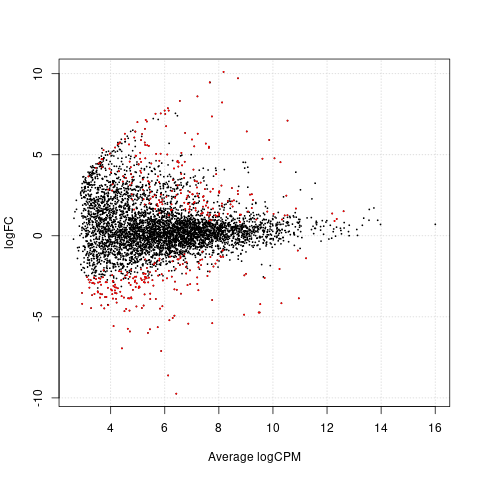

In [37]:
%%R
plotSmear(qlf, de.tags = rownames(tt)[which(tt$FDR< .01)])

# Visualisation

In [38]:
selected.X = selected.layers["counts"].copy()
sc.pp.normalize_total(selected, target_sum=1e6)
sc.pp.log1p(selected)

In [39]:
# add the table to .uns for each cell type
cell_type = 'C2+C3'
tt["gene_symbol"] = tt.index
tt["cluster"] = cell_type
sc_toolbox.tools.de_res_to_anndata(
    selected,
    tt,
    groupby="cluster",
    score_col="logCPM",
    pval_col="PValue",
    pval_adj_col="FDR",
    lfc_col="logFC",
    key_added="edgeR_" + cell_type,
)

In [40]:
ranked = sc.get.rank_genes_groups_df(
    selected, group="C2+C3", key="edgeR_C2+C3")
ranked = ranked.sort_values(by='scores')

# Week 2

Plotting 187 genes...


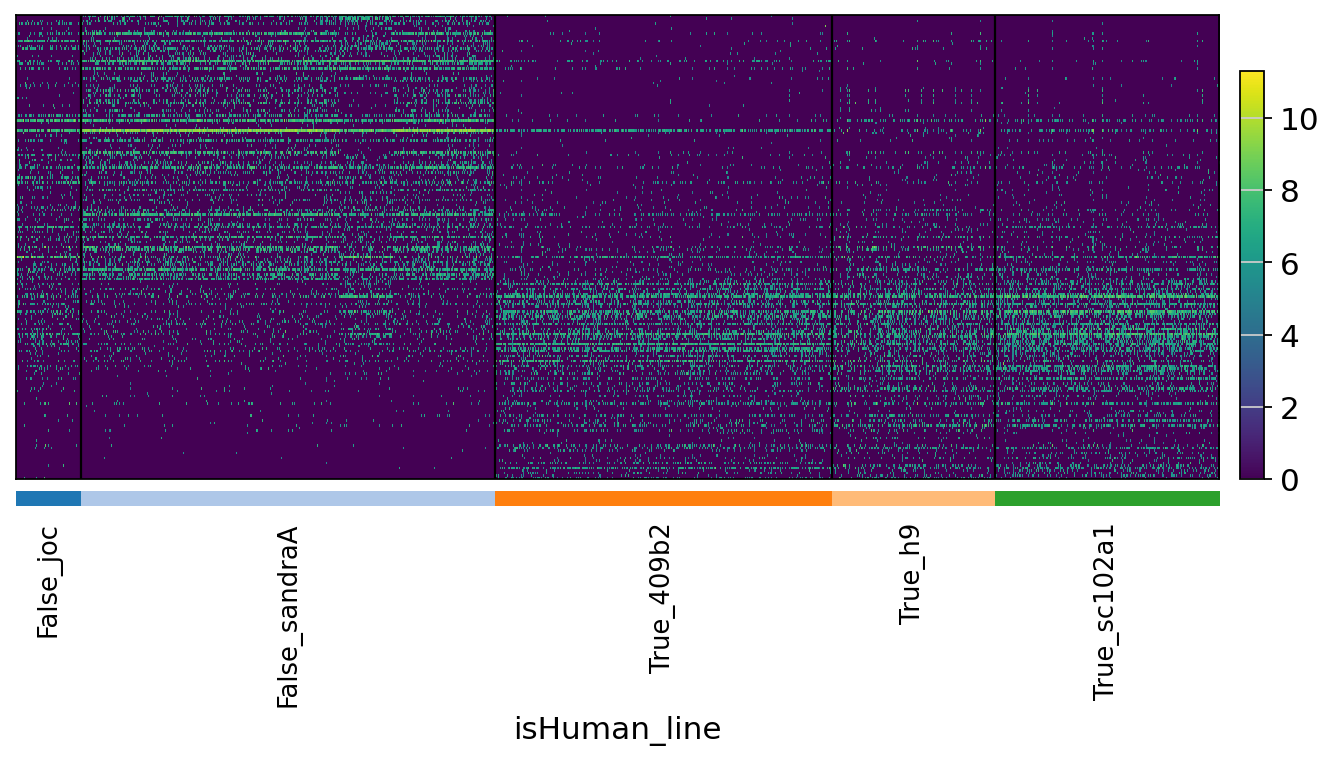

In [30]:
selected.obs.isHuman = selected.obs.isHuman.astype(str)
markers = vs.plot_heatmap(selected, "edgeR_C2+C3")

In [31]:
ranked.to_csv(config.PATHS.LOGS/'w2_markers.csv')
print(' '.join(markers))

GSTT2B NEMP1 BX255923.3 AC074183.4 PGM5P3-AS1 XCL1 C11orf70 MEIOB FCGBP KLF5 TUBA1C MTRNR2L10 TRABD2A NPIPB15 B3GLCT MCPH1-AS1 RP11-109E12.1 UHRF1 ATP5EP2 MEIG1 SVIL-AS1 MTRNR2L1 AC131056.3 HOXA3 CTD-2021H9.3 IRAK1 STK26 FAM162B CTSF CDC45 DLGAP5 AC010884.1 KIF2C SLC2A14 PBK MKI67 TEX22 CCDC81 TROAP NMRK2 CHKB-AS1 EMP1 MTRNR2L12 PLSCR1 RP6-99M1.3 NTF4 NBEAL1 ANXA11 LXN RP11-165A20.3 AC005523.2 FFAR4 E2F2 ECHDC3 DHDH BIRC5 MAP1LC3B2 HLA-E CADPS2 IL13RA1 C16orf95 MTRNR2L8 DYDC2 AC113189.5 SYT10 ASIC2 ITGA6 FAM101B HPS1 ZNF596 RMI2 PACSIN1 LIMD1 TUBA4A EIF5AL1 GRIN2A RP11-676J15.1 SORCS1 TBL1X AC005076.5 NPM3 DGCR9 PNP FBN3 SDC1 RP11-660L16.2 TOM1L1 CACHD1 BTBD11 SDC2 KANK1 SDCBP2-AS1 ARHGAP19 TIMP1 TUBB6 HSD17B8 RP11-480C16.1 VGF HEXB HEBP1 GLDC LRP10 EIF4A3 ETV4 PTGR1 PRCP NSMCE1 KCNB2 DNAJC12 SMPD3 LINC00665 ZFAND1 DACH1 RUNX1T1 ACAD8 FNDC5 C18orf32 SORCS2 CLN5 EBF3 RP3-525N10.2 PKIB CCNB1IP1 EXOSC3 SORBS2 RIN2 PCDH17 AC004540.4 EBF1 MAML3 SCD5 CYP51A1 ATP6V1G2 AC159540.1 DCTPP1 NT5DC2

# 28 Days Later

Plotting 552 genes...


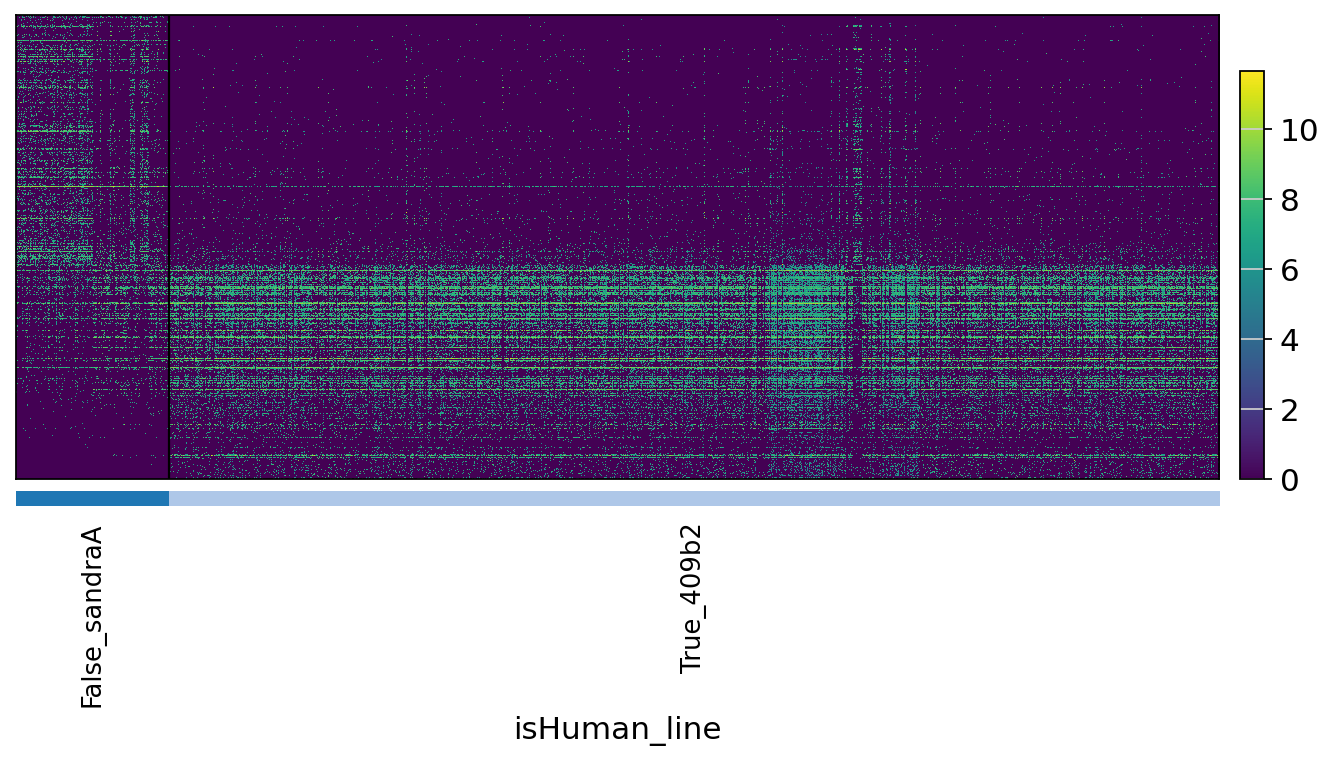

In [19]:
selected.obs.isHuman = selected.obs.isHuman.astype(str)
markers = vs.plot_heatmap(selected, "edgeR_C2+C3")

In [20]:
ranked.to_csv(config.PATHS.LOGS/'w4_markers.csv')
print(' '.join(markers))

MEIOB BX255923.3 GSTT2B AJAP1 CTSF COL4A6 MMRN1 PGM5P3-AS1 AC074183.4 PWP2 CYP1B1 RAB38 GJA1 TUBA1C OTX2 TEX22 TMEM132C CHL1 FOXJ1 NPY ACSF2 RSPO1 RGCC CRIP1 CYP26A1 DMRTA2 RBM47 MSX2 CDC42EP5 PALMD MTRNR2L12 GDPD2 ADAMTS16 ATP1A2 SLC2A14 TRABD2A MEIG1 ZIC3 HSD17B2 DSP COL9A1 S100A11 ATP6V1C2 HLA-E LRP2 RP11-109E12.1 ZIC2 MFAP4 AJUBA WLS ADGRG6 MOCOS MTRNR2L8 FCGBP CLDN1 TAGLN ZIC5 LAMB2 CDK2 ITGA5 RNF135 FAM129A HIST1H1D TK1 IGF2 GPX8 NPIPB15 COL4A5 ANXA1 PROM1 RAD51 NEIL3 COL3A1 EFS MDFIC TTK MYBL2 HMGA2 DKKL1 BACE2 ZIC1 EPHA2 RP13-39P12.3 FAM84B NEMP1 CCL2 UBE2C YAP1 MTRNR2L10 FLNC KIF20A ANKRD33B RP11-15H20.7 NUF2 THBS1 COL5A1 PAPSS2 RP11-110I1.6 FZD2 ZNF221 NR2F2-AS1 PRRX1 KLF5 RSPO3 SFRP2 LXN ECHDC3 RORA-AS1 OTX1 TGFA EMX2 CTSV RRM2 PRSS3 AGTRAP TEAD3 COL11A1 PTRF COL2A1 DLGAP1-AS2 PLAC9 NDC80 MYL9 CA2 VRK2 FAM83D TGIF1 FOXD4 LRRC17 DLGAP5 PMAIP1 EMP3 MGST1 IGFBP7 TBL1X LHX2 ZIC4 SPARC IGFBP2 FBN2 CHRDL1 RP11-255M2.3 LEF1 NEK2 RAB34 BMF FSTL1 CHKB-AS1 RBPMS IRAK1 CD9 ENO3 ANXA11 

# Week 5

Plotting 361 genes...


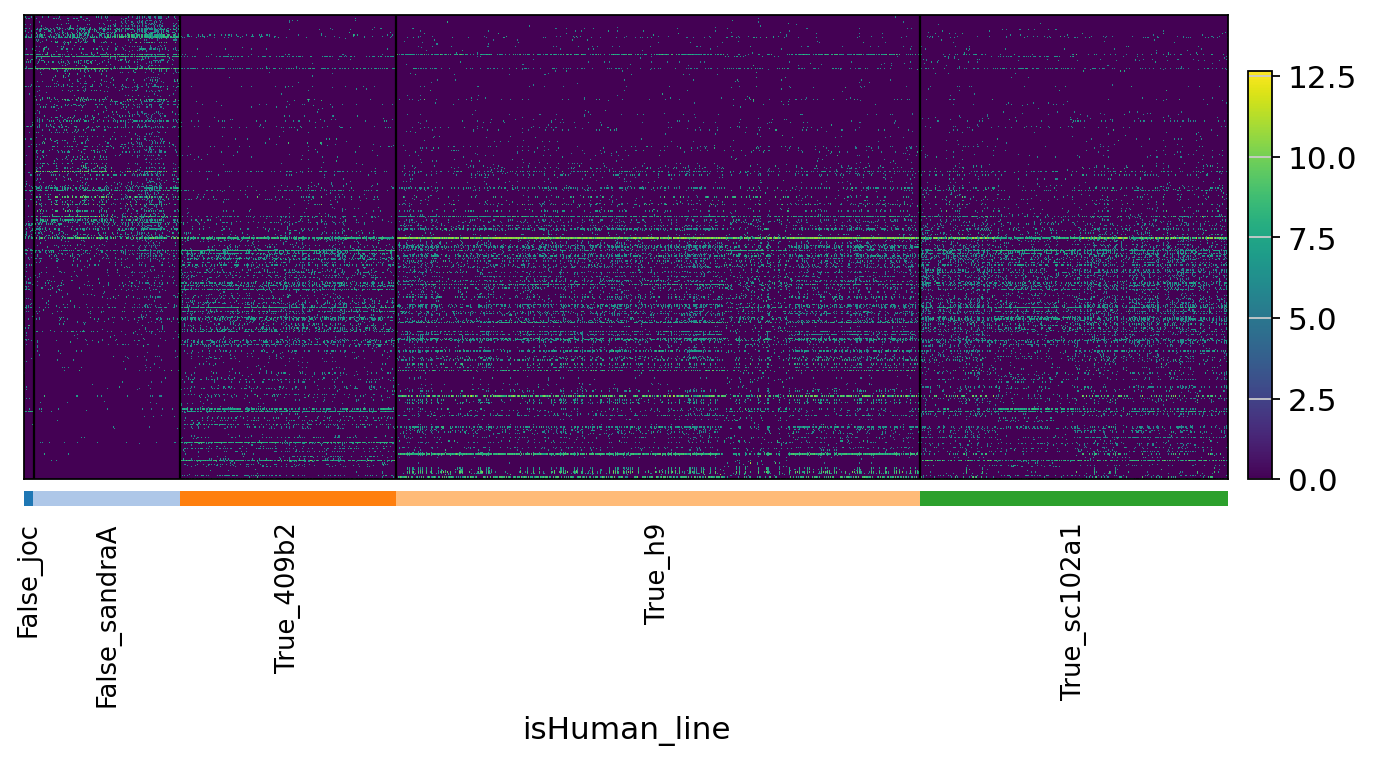

In [41]:
selected.obs.isHuman = selected.obs.isHuman.astype(str)
markers = vs.plot_heatmap(selected, "edgeR_C2+C3")

In [42]:
ranked.to_csv(config.PATHS.LOGS/'w5_markers.csv')
print(' '.join(markers))

BX255923.3 AC074183.4 MEIOB PGM5P3-AS1 RP11-255M2.3 XCL1 NEMP1 RP11-109E12.1 MTRNR2L10 FCGBP NPIPB15 GSTT2B TRABD2A MEIG1 BGN MTRNR2L1 MTRNR2L8 MTRNR2L12 SFRP4 TEX22 RP11-357H14.17 CYP1B1 HOXA7 TUBB8 KLF5 RP11-15H20.7 AC005523.2 ZNF221 ADGRG6 HOXA10 TUBA1C CTB-193M12.5 ATP5EP2 AC010884.1 PVALB CTSF RP13-39P12.3 CFI SLC2A14 SULT1E1 FOXD4 NBEAL1 COL8A1 FAP CEMIP HSD17B2 CLDN1 RP11-110I1.6 MCPH1-AS1 TRAC RP11-89K21.1 UHRF1 CTD-2021H9.3 TNFRSF10D AC131056.3 CHKB-AS1 LYNX1 SLC32A1 EMP1 CTC-360G5.9 RP11-491F9.1 PRSS3 TGFA RFPL2 HOXC9 IGFBP7 LRRC17 ADGRL2 DNM1P35 NHSL2 P3H2 B3GLCT AC138969.4 RORA-AS1 HOXA5 DGCR9 ZNF596 DHDH NPIPB6 COL12A1 ECHDC3 RP11-81A22.5 IRAK1 SALL3 SYK PLA2G7 MAP1LC3B2 EIF5AL1 ENG HOXB9 RP11-85O21.2 SYTL2 RP13-516M14.4 ELN SDCBP2-AS1 RP6-99M1.3 SYNPR DNM3OS OLFML2A ANOS1 RP11-16P6.1 AC005037.3 IL13RA1 PLEKHH2 CLDN11 ITGA1 RP11-166B2.1 CXCL2 PRDM8 AC113189.5 C7 LIF INHBA DLX2 CAPN6 NFIX RP11-480C16.1 HOXB-AS3 FBLN5 TGFB2 RP11-165A20.3 LGALS1 SHISA9 LXN FAM101B FFAR4 GGT5 

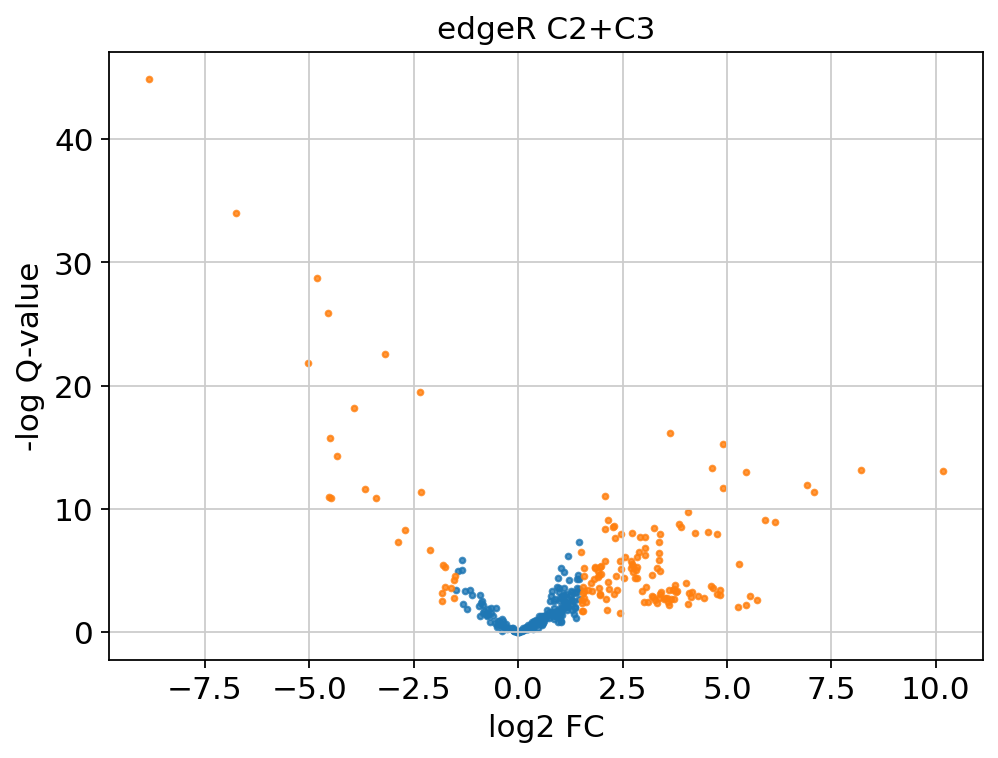

In [39]:
vs.volcano_plot(selected, "edgeR_C2+C3")